In [1]:
import re
from typing import Annotated, List, Dict, Any, Literal
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import BaseOutputParser
from langchain_ollama import ChatOllama


In [2]:
call_stack = []

In [3]:
class StripThinkParser(BaseOutputParser[str]):
    """Remove <think>...</think> and surrounding whitespace."""
    def parse(self, text: str) -> str:
        # Remove <think>...</think> sections
        cleaned = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
        # Also handle [think]...[/think] variations
        cleaned = re.sub(r"\[think\].*?\[/think\]", "", cleaned, flags=re.DOTALL)
        # Remove extra whitespace
        cleaned = cleaned.strip()
        # Log the parsing operation
        call_stack.append(f"StripThinkParser.parse: cleaned text (length: {len(text)} -> {len(cleaned)})")
        return cleaned

In [4]:
llm = ChatOllama(model="gemma3:1b", temperature=0)
parser = StripThinkParser()

In [5]:
class TeamState(TypedDict):
    messages: Annotated[List[Any], "Messages in the conversation"]
    task: str
    team_structure: Dict[str, Any]
    ceo_response: str
    manager_responses: Dict[str, str]
    worker_responses: Dict[str, str]
    final_output: str
    current_agent: Literal["ceo", "manager_1", "manager_2", "worker_1", "worker_2", "worker_3", "synthesizer"]


In [6]:
TEAM_STRUCTURE = {
    "ceo": {
        "role": "Chief Executive Officer",
        "responsibility": "Overall strategy and task decomposition"
    },
    "managers": {
        "manager_1": {
            "role": "Operations Manager",
            "responsibility": "Planning and resource allocation"
        },
        "manager_2": {
            "role": "Quality Manager",
            "responsibility": "Review and quality assurance"
        }
    },
    "workers": {
        "worker_1": {
            "role": "Research Analyst",
            "responsibility": "Data collection and analysis"
        },
        "worker_2": {
            "role": "Content Creator",
            "responsibility": "Content development and drafting"
        },
        "worker_3": {
            "role": "Technical Specialist",
            "responsibility": "Technical implementation and review"
        }
    }
}


In [7]:
def ceo_node(state: TeamState) -> Dict[str, Any]:
    """CEO decomposes the task and assigns to managers"""
    call_stack.append("ceo_node: Executing")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the CEO of a company. First, think about your approach in <think> tags, then provide your response.
        
        Your role is to:
        1. Understand the high-level task
        2. Break it into strategic components
        3. Assign specific responsibilities to your direct reports
        
        Team Structure:
        - Operations Manager: Planning and resource allocation
        - Quality Manager: Review and quality assurance"""),
        ("user", "Task: {task}\n\n<think>First, I need to consider the strategic approach...</think>")
    ])
    
    chain = prompt | llm | parser
    ceo_response = chain.invoke({"task": state["task"]})
    
    call_stack.append(f"ceo_node: Completed with response length {ceo_response}")
    
    return {
        "ceo_response": ceo_response,
        "current_agent": "manager_1"
    }


In [8]:
def manager_node(manager_id: str):
    """Factory function to create manager nodes"""
    def node(state: TeamState) -> Dict[str, Any]:
        call_stack.append(f"manager_node ({manager_id}): Executing")
        
        manager_info = TEAM_STRUCTURE["managers"][manager_id]
        
        # Get previous responses for context
        context = f"CEO's Strategic Direction:\n{state['ceo_response']}\n\n"
        
        # Include previous manager responses if applicable
        if manager_id == "manager_2" and "manager_1" in state.get("manager_responses", {}):
            context += f"Operations Manager's Plan:\n{state['manager_responses']['manager_1']}\n\n"
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", f"""You are the {manager_info['role']}. First, think about your approach in <think> tags, then provide your response.
            
            Your responsibility is {manager_info['responsibility']}.
            
            Based on the CEO's direction, develop your specific approach and assign tasks to your team members.
            
            Team Members:
            - Research Analyst: Data collection and analysis
            - Content Creator: Content development and drafting
            - Technical Specialist: Technical implementation and review"""),
            ("user", f"{context}\nTask: {state['task']}\n\n<think>Let me consider my management approach...</think>")
        ])
        
        chain = prompt | llm | parser
        manager_response = chain.invoke({})
        
        # Update manager responses
        manager_responses = state.get("manager_responses", {}).copy()
        manager_responses[manager_id] = manager_response
        
        # Determine next agent
        next_agent = "manager_2" if manager_id == "manager_1" else "worker_1"
        
        call_stack.append(f"manager_node ({manager_id}): Completed with response length {manager_response}")
        
        return {
            "manager_responses": manager_responses,
            "current_agent": next_agent
        }
    
    return node

In [9]:
def worker_node(worker_id: str):
    """Factory function to create worker nodes"""
    def node(state: TeamState) -> Dict[str, Any]:
        call_stack.append(f"worker_node ({worker_id}): Executing")
        
        worker_info = TEAM_STRUCTURE["workers"][worker_id]
        
        # Build context from hierarchy
        context = f"Task: {state['task']}\n\n"
        context += f"CEO Direction:\n{state['ceo_response']}\n\n"
        
        # Add relevant manager instructions
        if worker_id in ["worker_1", "worker_2"] and "manager_1" in state.get("manager_responses", {}):
            context += f"Operations Manager Instructions:\n{state['manager_responses']['manager_1']}\n\n"
        elif worker_id == "worker_3" and "manager_2" in state.get("manager_responses", {}):
            context += f"Quality Manager Instructions:\n{state['manager_responses']['manager_2']}\n\n"
        
        prompt = ChatPromptTemplate.from_messages([
            ("system", f"""You are the {worker_info['role']}. First, think about your approach in <think> tags, then provide your response.
            
            Your responsibility is {worker_info['responsibility']}.
            
            Execute your assigned task based on the instructions from your managers.
            Provide detailed, high-quality work product."""),
            ("user", f"{context}\n\n<think>Let me approach this task systematically...</think>")
        ])
        
        chain = prompt | llm | parser
        worker_response = chain.invoke({})
        
        # Update worker responses
        worker_responses = state.get("worker_responses", {}).copy()
        worker_responses[worker_id] = worker_response
        
        # Determine next agent
        worker_order = ["worker_1", "worker_2", "worker_3"]
        current_index = worker_order.index(worker_id)
        next_agent = worker_order[current_index + 1] if current_index < len(worker_order) - 1 else "synthesizer"
        
        call_stack.append(f"worker_node ({worker_id}): Completed with response length {worker_response}")
        
        return {
            "worker_responses": worker_responses,
            "current_agent": next_agent
        }
    
    return node

In [10]:
def synthesizer_node(state: TeamState) -> Dict[str, Any]:
    """Integrates all team outputs into final deliverable"""
    call_stack.append("synthesizer_node: Executing")
    
    # Build comprehensive context
    context = f"Original Task: {state['task']}\n\n"
    context += f"CEO Strategic Direction:\n{state['ceo_response']}\n\n"
    
    # Add manager contributions
    for manager_id, response in state.get("manager_responses", {}).items():
        manager_name = TEAM_STRUCTURE["managers"][manager_id]["role"]
        context += f"{manager_name} Contribution:\n{response}\n\n"
    
    # Add worker contributions
    for worker_id, response in state.get("worker_responses", {}).items():
        worker_name = TEAM_STRUCTURE["workers"][worker_id]["role"]
        context += f"{worker_name} Work Product:\n{response}\n\n"
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Chief of Staff responsible for synthesizing team outputs into a cohesive final deliverable.
        First, think about your approach in <think> tags, then provide your response.
        
        Your task is to:
        1. Integrate all contributions into a unified response
        2. Ensure consistency across all sections
        3. Fill any gaps in the deliverable
        4. Present a professional, comprehensive final product"""),
        ("user", f"{context}\n\n<think>Let me synthesize all these contributions...</think>")
    ])
    
    chain = prompt | llm | parser
    final_output = chain.invoke({})
    
    call_stack.append(f"synthesizer_node: Completed with response length {final_output}")
    
    return {
        "final_output": final_output,
        "current_agent": "end"
    }

In [11]:
def router(state: TeamState) -> str:
    """Determine which agent to execute next"""
    call_stack.append(f"router: Current agent is {state['current_agent']}")
    return state["current_agent"]


In [12]:
from langgraph.graph import StateGraph, END, START

builder = StateGraph(TeamState)

# Add nodes
builder.add_node("ceo", ceo_node)
builder.add_node("manager_1", manager_node("manager_1"))
builder.add_node("manager_2", manager_node("manager_2"))
builder.add_node("worker_1", worker_node("worker_1"))
builder.add_node("worker_2", worker_node("worker_2"))
builder.add_node("worker_3", worker_node("worker_3"))
builder.add_node("synthesizer", synthesizer_node)

# Add edges following the hierarchy
builder.add_edge(START, "ceo")
builder.add_edge("ceo", "manager_1")
builder.add_edge("manager_1", "manager_2")
builder.add_edge("manager_2", "worker_1")
builder.add_edge("worker_1", "worker_2")
builder.add_edge("worker_2", "worker_3")
builder.add_edge("worker_3", "synthesizer")
builder.add_conditional_edges(
    "synthesizer",
    router,
    {
        "end": END
    }
)

# Compile the graph
hierarchical_team = builder.compile()

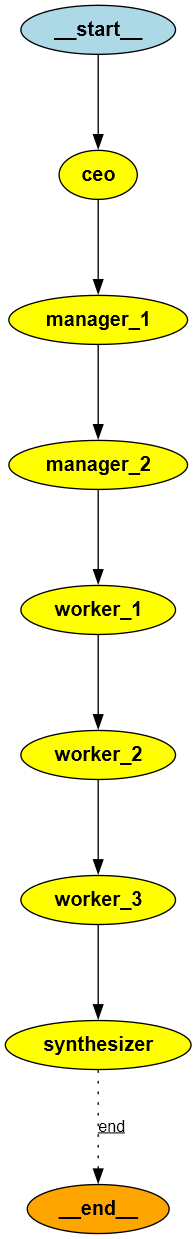

In [13]:
from IPython.display import Image, display
display(Image(hierarchical_team.get_graph().draw_png()))

In [14]:
def run_hierarchical_team(task: str) -> Dict[str, Any]:
    """Run the hierarchical team with a task"""
    # Clear call stack for new execution
    global call_stack
    call_stack = []
    call_stack.append("run_hierarchical_team: Starting execution")
    
    initial_state = TeamState(
        messages=[HumanMessage(content=task)],
        task=task,
        team_structure=TEAM_STRUCTURE,
        ceo_response="",
        manager_responses={},
        worker_responses={},
        final_output="",
        current_agent="ceo"
    )
    
    result = hierarchical_team.invoke(initial_state)
    
    # Format the output for clarity
    output = {
        "task": task,
        "team_structure": TEAM_STRUCTURE,
        "ceo_direction": result["ceo_response"],
        "management_contributions": result["manager_responses"],
        "worker_deliverables": result["worker_responses"],
        "final_deliverable": result["final_output"],
        "execution_trace": call_stack  # Include the execution trace
    }
    
    call_stack.append("run_hierarchical_team: Execution completed")
    
    return output

In [15]:
task = "Develop a comprehensive marketing strategy for launching a new AI-powered productivity app"
    
print("=== Hierarchical Team Processing ===")
print(f"Task: {task}\n")

result = run_hierarchical_team(task)

print("CEO Strategic Direction:")
print(result['ceo_direction'][:500] + "..." if len(result['ceo_direction']) > 500 else result['ceo_direction'])
print("\n" + "-"*50 + "\n")

print("Management Contributions:")
for manager_id, contribution in result['management_contributions'].items():
    role = TEAM_STRUCTURE['managers'][manager_id]['role']
    print(f"\n{role}:")
    print(contribution[:300] + "..." if len(contribution) > 300 else contribution)

print("\n" + "-"*50 + "\n")

print("Worker Deliverables:")
for worker_id, deliverable in result['worker_deliverables'].items():
    role = TEAM_STRUCTURE['workers'][worker_id]['role']
    print(f"\n{role}:")
    print(deliverable[:200] + "..." if len(deliverable) > 200 else deliverable)

print("\n" + "="*50 + "\n")

print("FINAL DELIVERABLE:")
print(result['final_deliverable'])

print("\n" + "="*50 + "\n")

print("EXECUTION TRACE:")
for i, trace in enumerate(result['execution_trace'][:20], 1):  # Show first 20 traces
    print(f"{i:2d}. {trace}")

if len(result['execution_trace']) > 20:
    print(f"... and {len(result['execution_trace']) - 20} more traces")

print("\n" + "="*50 + "\n")
print(call_stack)
print("\n" + "="*50 + "\n")

=== Hierarchical Team Processing ===
Task: Develop a comprehensive marketing strategy for launching a new AI-powered productivity app

CEO Strategic Direction:
Okay, let’s start with the strategic approach. Here’s my initial thinking:

**Think:**

1.  **Understanding the Market & Target Audience:** We need a deep understanding of the competitive landscape, current productivity trends, and *specifically* who will use this AI app.  We can’t just launch into broad marketing; we need to laser in on a niche.  What problem does this app solve *better* than existing solutions?

2.  **Defining the Value Proposition:** What *unique* benefits does this AI app of...

--------------------------------------------------

Management Contributions:

Operations Manager:
Okay, that’s a great starting point. I agree with the overall approach – it’s well-structured and focuses on a phased launch. Let’s refine it a bit. My initial thoughts are that the “Market Research” phase is *absolutely* critical and n